In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import multiprocessing
import time
import math

from IPython.display import clear_output
warnings.filterwarnings('ignore')

In [2]:
from src.sigsimulation import *
from src.robustper import robustper_wrap, mltproc_robustper_wrap
from src.baywatch import baywatch_wrap, mltproc_baywatch_wrap
from src.statsbased import stats_wrap, mltproc_stats_wrap
from src.upnsca import upnsca_wrap, mltproc_upnsca_wrap
from src.bcndetection import bcndetection_wrap, mltproc_bcndetection_wrap

## Insertion Noise Simulation

----

- This notebook demo compares our proposed algorithm with several other periodicity detection algorithms using synthetic signals. 
- Please refer to paper `Section 4.2 Algorithm Evaluation` for detailed explanation of the insertion noise.
- The following parameters are pre-defined to be consistant with the paper. 

In [56]:
# 10 minutes periodicity
perl = [10]

# std = 0 for the insertion experiment
std = 0.

# insertion percentage is from 0 to 20 of the original period
instl = [i for i in range(0, 22, 2)]

# for each insertion percentage, we generate $cnt signals
cnt = 100

datarootdir = "data/inst"

if not os.path.exists(datarootdir):
    os.mkdir(datarootdir)

datafilefmt = "per_{}_inst_{}.parquet"

# load pregenerated signal, set to True to regenerate simulated signals
regenerate = False

### Generate/Load Signals

If you want to **regenerate** signals, set the `regenerate=True`.
(By default, we load our previously generated signals to speed up the process.)


In [57]:
# load pre-generated signal
# set to True to regenerate simulated signals
regenerate = False

### Multiprocessing to reduce the computation time
- set `multiproc=False` to disable multiprocessing. (We recommand use multiprocessing to speed up the computation.)
- set the `processors`=`$number_of_your_cpu_cores` or `$number_of_jobs` you want to run in parallel.

In [58]:
# Set multiproc to True to disable multiprocessing
multiproc = True

# set the processors = the number of cpu cores or the number of jobs
processors = 16

### Algorithm Evaluation
- Run the following blocks to regenerate results for STATS-based, UPNSCA, BAYWATCH and **our proposed methods**.
- **The unofficial implementation of RobustPeriod is very slow**. It usually take minutes to process one time seires, as a result, it would take hours to complete the Gaussian noise evaluation section. Therefore, we read the robustperiod results from our previous evaluation here for convenience purporse.
- **The code blocks to re-run the whole RobustPeriod experiments** are provided at the end of this notebook, in case you want to re-run the RobustPeriod results. It usually takes hours to finish depending on the computation power of your computer.

In [59]:
# we define acc = detected / total
def get_acc(res, totalcnt):
    return res.loc[res["detected"]==True].shape[0]/totalcnt

### The main detection process:

In [60]:
# init result dataframe
statsdf = pd.DataFrame(columns=["per", "std", "inst", "acc", "method"]) 

# start evalutaion
for per_m in perl:
    per = per_m * 60 # minute to seconds
    print("Generating Signals of Periodicity: {} minutes".format(per_m))
    
    for value in instl:
        inst = float(value)/100
        print("insertion range: {} %".format(value))
        datafpath = os.path.join(datarootdir, datafilefmt.format("{0:03d}".format(per_m), "{0:03d}".format(int(value))))
        print(datafpath)
        
        # Load or generate simulated signals
        if not regenerate and os.path.exists(datafpath):
            print("Loading data...")
            sigdf = pd.read_parquet(datafpath)
        else:
            print("ReGenerating data...")
            sigdf = gen_poisson_signal_df(per, std, prate=inst, count=cnt)
            print("Saving data...")
            sigdf.to_parquet(datafpath, index=False)

        if multiproc: 
            
            # STATBASED
            print("Processing STATSBASED detection...")
            stats_resdf = mltproc_stats_wrap(sigdf, maxproc=processors)
            
            # UPNSCA
            print("Processing UPNSCA detection...")
            upnsca_resdf = mltproc_upnsca_wrap(sigdf, maxproc=processors)
            
            # BAYWATCH
            print("Processing BAYWATCH detection...")
            baywatch_resdf = mltproc_baywatch_wrap(sigdf, maxproc=processors)
        
            # Our Proposed
            print("Processing Our Proposed detection...")
            bcndetection_resdf = mltproc_bcndetection_wrap(sigdf, maxproc=processors)
        else:
            
            # STATBASED
            print("Processing STATSBASED detection...")
            stats_resdf = stats_wrap(sigdf)
            
            # UPNSCA
            print("Processing UPNSCA detection...")
            upnsca_resdf = upnsca_wrap(sigdf)
            
            # BAYWATCH
            print("Processing BAYWATCH detection...")
            baywatch_resdf = baywatch_wrap(sigdf)
        
            # Our Proposed
            print("Processing Our Proposed detection...")
            bcndetection_resdf = bcndetection_wrap(sigdf)
        
        print("Getting Stats...")
        stats_acc = get_acc(stats_resdf, totalcnt=cnt)
        upnsca_acc = get_acc(upnsca_resdf, totalcnt=cnt)
        baywatch_acc = get_acc(baywatch_resdf, totalcnt=cnt)
        bcndetection_acc = get_acc(bcndetection_resdf, totalcnt=cnt)
        
        print("PERIODS:{}, STD: {}, INST: {} \nSTATS: {}\nUPNSCA: {}\nBAYWATCH: {}\nOUR Proposed: {}\n".format(per_m, std, inst, stats_acc, upnsca_acc, baywatch_acc, bcndetection_acc))
        
        ## update statatistic dataframe for plotting.
        statsdf = statsdf.append({"per": per, "std": std, "inst": value, "acc": stats_acc, "method": "STATS-BASED"}, ignore_index=True)
        statsdf = statsdf.append({"per": per, "std": std, "inst": value, "acc": upnsca_acc, "method": "UPNSCA"}, ignore_index=True)
        statsdf = statsdf.append({"per": per, "std": std, "inst": value, "acc": baywatch_acc, "method": "BAYWATCH"}, ignore_index=True)
        statsdf = statsdf.append({"per": per, "std": std, "inst": value, "acc": bcndetection_acc, "method": "Our Proposed"}, ignore_index=True)
        clear_output(wait=True)

insertion range: 20 %
data/inst/per_010_inst_020.parquet
Loading data...
Processing STATSBASED detection...
Processing UPNSCA detection...
Processing BAYWATCH detection...
Processing Our Proposed detection...
Getting Stats...
PERIODS:10, STD: 0.0, INST: 0.2 
STATS: 0.0
UPNSCA: 0.0
BAYWATCH: 1.0
OUR Proposed: 1.0



### Save the results
If you **regenerate** signals, uncomment and run the following blocks to save it.

In [64]:
#statsdf.to_csv("results/inst_evaluation.csv", index=False)

### Visualization
- We read RobustPeriod results from "results/inst_robust.csv" as the rerunning of RobustPeriod would take hours. (The re-runing code for robustPeriod can be found at the end of the notebook.)

In [65]:
statsdf_robust = pd.read_csv("results/inst_robust.csv")
statsdf = pd.read_csv("results/inst_evaluation.csv")
statsdf_all = pd.concat([statsdf, statsdf_robust], ignore_index=True)

### Plotting the periodicity detection results. 
- **Note** that the figure might be slightly **different** from the figure in the paper due to the **random process** in **both** signal generation and periodicity detection process, which may cause more or less detections. 

- However, we expect the pattern to be **very similar**: 
- We expect STATS-BASED, UPNSCA have the worst performance. The lines might be overlapped, because these algorithms are not robust to the insertion noise so they drop to 0 very quickly. 
- We expect Baywatch has better performance as compared to the upper-mentioned algorithms. 
- Both RobustPeriod and ours are very robust (i.e. 100% detection rate) to insertion noise and **overlapped** as the top line.

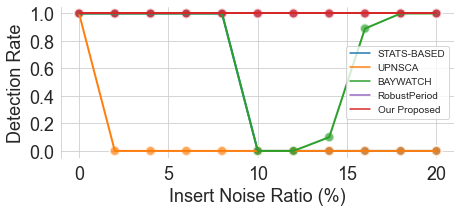

In [63]:
stats_per10 = statsdf_all.loc[statsdf_all["per"]==600]

sns.set_style("whitegrid")
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

fig, ax0 = plt.subplots(figsize=(6, 3))

sns.set_palette("tab10")

ax0 = sns.scatterplot(data=stats_per10, x = "inst", y="acc", hue="method", x_jitter=100, y_jitter=100,  linewidth=2, alpha=0.7, s=100, 
                      palette=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[3]], 
                      legend = False)
ax0 = sns.lineplot(data=stats_per10, x = "inst", y="acc", hue="method", markers="acc", linewidth=2,
                   palette=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[3]])

ax0.set_ylabel("Detection Rate",  fontsize=18)
ax0.set_xlabel("Insert Noise Ratio (%)",  fontsize=18)
ax0.tick_params(axis='x', labelsize=18)
ax0.tick_params(axis='y', labelsize=18)
ax0.set_yticks(np.arange(0, 1.2, step=0.2))

handle, labels = ax0.get_legend_handles_labels()
plt.legend(labels=[labels[0], labels[1], labels[2], labels[4], labels[3]], 
           handles= [handle[0], handle[1], handle[2], handle[3], handle[4]], )

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.subplots_adjust(0.07, 0.15, 0.98, 0.85)

### RobustPeriods Demo
- Run the following blocks to check the computation time for robust periods to process one time series
- It usually take 40 seconds to process one time series with different omitting rate on my computer (MacBook pro 2018 with 2.5GHz Quad Cores).

In [17]:
demo_sigdf = gen_poisson_signal_df(per, std=0, prate=0.02, count=1)
print(demo_sigdf)

start_t = time.time()
demo_res = robustper_wrap(demo_sigdf)
end_t = time.time()
print("Processing time is: {} seconds".format(end_t - start_t))

                                                 tdf  ts_cnt
0  [6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     144
Processing time is: 34.49331068992615 seconds


### RobustPeriods Rerun
- Run the following blocks to recompute the whole RobustPeriod evaluation session
- **[Warning]** Note that it usually takes hours to finish. 
- For example, we want to test 20 std values. For each std value, 100 signals are generated. And for each signal series,  the algorithm need 40 seconds processing time. If the computer has 16 cores, it will take 20 * 100 * 40 / 16 = 1.4 hours. 

In [32]:
stats_robust = pd.DataFrame(columns=["per", "std", "inst", "acc", "method"]) 
regenerate = False
for per_m in perl:
    per = per_m * 60 # minute to seconds
    print("Generating Signals of Periodicity: {} minutes".format(per_m))
    
    for value in instl:
        inst = float(value)/100
        print("Gaussian Noise Level: {} %".format(value))
        datafpath = os.path.join(datarootdir, datafilefmt.format("{0:03d}".format(per_m), "{0:03d}".format(value)))
        print(datafpath)
        
        # Load or generate simulated signals
        if not regenerate and os.path.exists(datafpath):
            print("Loading data...")
            sigdf = pd.read_parquet(datafpath)
        else:
            print("ReGenerating data...")
            sigdf = gen_poisson_signal_df(per, std, prate=inst, count=cnt)
            print("Saving data...")
            sigdf.to_parquet(datafpath, index=False)

        if multiproc: 
            print("Processing RobustPeriod detection...")
            robust_resdf = mltproc_robustper_wrap(sigdf, maxproc=processors)
        else:
            print("Processing RobustPeriod detection...")
            robust_resdf = robustper_wrap(sigdf)
        
        print("Getting Stats...")
        robust_acc = get_acc(robust_resdf, totalcnt=cnt)
        
        print("PERIODS:{}, STD: {}, INST: {} \nRobustPeriods: {}\n".format(per_m, std, inst, robust_acc))
        
        ## update statatistic dataframe for plotting.
        stats_robust = stats_robust.append({"per": per, "std": std, "inst": value, "acc": robust_acc, "method": "RobustPeriod"}, ignore_index=True)
        clear_output(wait=True)

Gaussian Noise Level: 20 %
data/poisson/per_010_inst_020.parquet
Loading data...
Processing RobustPeriod detection...
Getting Stats...
PERIODS:10, STD: 0.0, INST: 0.2 
RobustPeriods: 1.0



### Save Results
Save your newly computed robust period data by uncomment the following line

In [34]:
#stats_robust.to_csv("results/inst_robust.csv", index=False)

### Signal Visualization

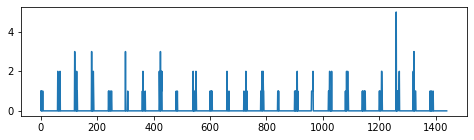

In [3]:
sig = add_poisson_insert(60*60, prate=0.2)
resig = resample_sig(sig)
fig = plt.figure(figsize=(8,2))
plt.plot(resig)